# 9-3 영어/한국어 Word2Vec

## 1. 영어 Word2Vec 만들기

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize


#### 1) 훈련 데이터 이해하기
- XML 로 데이터 전처리 필요

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x1fd56994a50>)

#### 2) 전처리

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\claia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [5]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

parse_text = '\n'.join(target_text.xpath('//content/text()'))

content_text = re.sub(r'\([^)]*\)', '', parse_text) # 정규식 공부 좀...

# tokenization
sent_text = sent_tokenize(content_text)

normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)
    
result = [word_tokenize(sentence) for sentence in normalized_text]

In [6]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [7]:
for line in result[:3] :
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


#### 3) Word2Vec 훈련
- vector_size : 워드 벡터의 특징 값 == 임베딩 된 벡터 차원
- window size : context win size
- min_count : 단어 최소 빈도수 제한 (특정 빈도수 이하는 학습 X)
- workers : 학습을 위한 prcss 수
- sg : 0 CBOW, 1 skip-gram

In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

model.wv.most_similar("word") : word 와 가장 유사한 단어

In [10]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8445554375648499), ('guy', 0.8312541842460632), ('boy', 0.7843965888023376), ('lady', 0.7830336093902588), ('girl', 0.7742052674293518), ('kid', 0.7274744510650635), ('soldier', 0.7233458161354065), ('gentleman', 0.7009499073028564), ('poet', 0.6948195695877075), ('david', 0.6711035370826721)]


#### 4) Word2Vec 모델 저장 및 로드

In [11]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [12]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8445554375648499), ('guy', 0.8312541842460632), ('boy', 0.7843965888023376), ('lady', 0.7830336093902588), ('girl', 0.7742052674293518), ('kid', 0.7274744510650635), ('soldier', 0.7233458161354065), ('gentleman', 0.7009499073028564), ('poet', 0.6948195695877075), ('david', 0.6711035370826721)]


## 2. 한국어 Word2Vec 만들기 with naver movie review

In [14]:
!pip install konlpy
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

  Using cached konlpy-0.6.0-py2.py3-none-any.whl (19.4 MB)
  Obtaining dependency information for JPype1>=0.7.0 from https://files.pythonhosted.org/packages/1f/19/144f3a767b563ba5c6d4aa534ea1f3fad9a5067c3917df4458a6e1afe0ef/JPype1-1.5.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/351.5 kB ? eta -:--:--
   --------------------------------------- 351.5/351.5 kB 11.0 MB/s eta 0:00:00


In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x1fd366eee90>)

#### 1) 데이터 확인

In [17]:
train_data = pd.read_table('ratings.txt')
train_data[:5] # 상위 5개 출력


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [18]:
print(len(train_data))

200000


#### 2) 데이터 전처리

In [19]:
print(train_data.isnull().values.any())

True


In [20]:
train_data = train_data.dropna(how = "any")
print(train_data.isnull().values.any())

False


In [21]:
print(len(train_data))

199992


In [22]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [23]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


불용어 Stop Word : 조사 접속사 등 분석에 의미 X 단어

In [25]:
!pip install tqdm

In [30]:
from tqdm import tqdm

In [31]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 199992/199992 [43:11<00:00, 77.16it/s]


리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.338453538141525


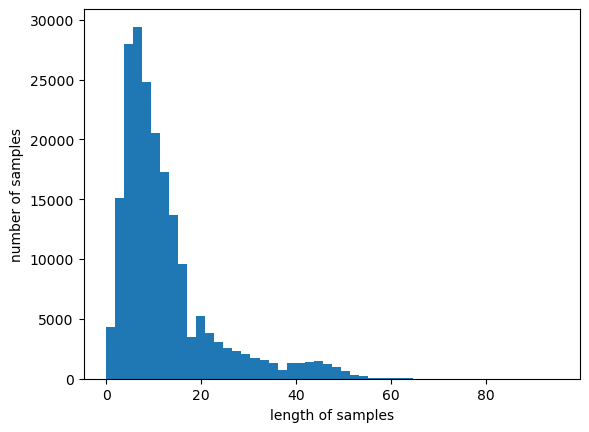

In [32]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [33]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)


In [34]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(17615, 100)

In [35]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8442171812057495), ('유다인', 0.8248986005783081), ('송강호', 0.8163918852806091), ('안성기', 0.8100661039352417), ('박중훈', 0.8089741468429565), ('김명민', 0.8054014444351196), ('엄정화', 0.7967633605003357), ('정재영', 0.7963742017745972), ('설경구', 0.7927967309951782), ('조승우', 0.7921444773674011)]


In [36]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8739850521087646), ('호러', 0.8499945998191833), ('무협', 0.8276097178459167), ('물의', 0.8205141425132751), ('SF', 0.8203659653663635), ('느와르', 0.8189937472343445), ('물', 0.8064559698104858), ('무비', 0.8025552034378052), ('블록버스터', 0.7976530194282532), ('정통', 0.7935786247253418)]


## 3. 사전 훈련된 Word2Vec embedding

In [ ]:
print(word2vec_model.vectors.shape)

#model issue

# 9-4 네거티브 샘플링을 이용한 Word2Vec

## 1. 네거티브 샘플링
- Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법

## 2. 네거티브 샘플링 Skip-Gram with Negative Sampling, SGNS
- 기존 Skip-Gram : 중신 단어로부터 주변 단어 예측
- 네거티브 샘플링 Skip-Gram(Skip-Gram with Negative Sampling, SGNS) : 중심 단어와 주변 단어 모두 입력. 실제 win size 에 존재하는 이웃 관계인지 확률 예측

## 3. 실습

#### 1. 20 뉴스 그룹 데이터 전처리

In [42]:
!pip install tensorflow

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  

In [43]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [45]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [46]:
news_df.isnull().values.any()
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 11004


In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\claia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [51]:
# 불용어 제거
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [59]:
# 패딩 추가
max_len = max(len(sentence) for sentence in tokenized_doc)
tokenized_doc_padded = [sentence + [0] * (max_len - len(sentence)) for sentence in tokenized_doc]

MemoryError: Unable to allocate 54.4 GiB for an array with shape (10961, 6230) and data type <U214

In [61]:
batch_size = 32
num_batches = len(tokenized_doc_padded) // batch_size

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_data = np.array(tokenized_doc_padded[start_idx:end_idx])
    
    # 여기에서 배치 데이터를 사용하여 모델을 훈련하거나 다른 처리 수행
    
# 마지막 배치 처리
if len(tokenized_doc_padded) % batch_size != 0:
    last_batch_data = np.array(tokenized_doc_padded[num_batches * batch_size:])
    # 여기에서 마지막 배치 데이터를 사용하여 모델을 훈련하거나 다른 처리 수행


In [62]:
print('총 샘플 수:', len(tokenized_doc))

총 샘플 수: 10961


In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [64]:
print(encoded[:2])

[[40, 53, 927, 143, 15889, 1684, 546, 279, 871, 12028, 17773, 24007, 29726, 279, 871, 63435, 871, 1128, 1103, 1998, 851, 29727, 913, 731, 20477, 279, 871, 170, 143, 1811, 149, 279, 20478, 17773, 6645, 5710, 76, 63436, 7, 36, 165, 614, 653, 29728, 6911, 24008, 2082, 829, 17774, 1119, 8790, 355, 1072, 15890, 671, 57, 163, 4231, 7206, 1933, 440, 56, 282, 4730, 9275, 2690, 39306], [1283, 429, 3, 52, 6164, 159, 112, 474, 89, 17775, 18, 63, 4731, 2865, 63437, 1042, 402, 39307, 8791, 902, 44, 8328, 316, 13041, 902, 3452, 5923, 533, 18, 87, 4732, 9872, 160, 1403, 120, 151, 5194, 63438, 63439, 17776, 63440, 13041, 903, 63441, 63442, 11172, 17777]]


In [65]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 181839


## 4. 네거티브 샘플링을 통한 데이터셋 구성

In [66]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]


In [67]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))


(occured. (20477), paananen (176100)) -> 0
(blessing (15890), all, (440)) -> 1
(received (671), trdatovs (168626)) -> 0
(soldiers (1072), impaitent (69982)) -> 0
(media (871), (ear). (140957)) -> 0


In [68]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [69]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2460
2460


In [70]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]


## 5. Skip-Gram with Negative Sampling(SGNS) 구현하기

In [71]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG


In [72]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)


In [73]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               1818390   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               1818390   ['input_2[0][0]']         

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)


## 6. 결과 확인

In [ ]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)


In [ ]:
w2v.most_similar(positive=['soldiers'])


# 9-5. Glove

In [ ]:
pip install glove_python_binary

In [ ]:
from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(result, window=5)
glove = Glove(no_components=100, learning_rate=0.05)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)


In [ ]:
print(glove.most_similar("man"))


In [ ]:
print(glove.most_similar("boy"))


## 4. 손실 함수
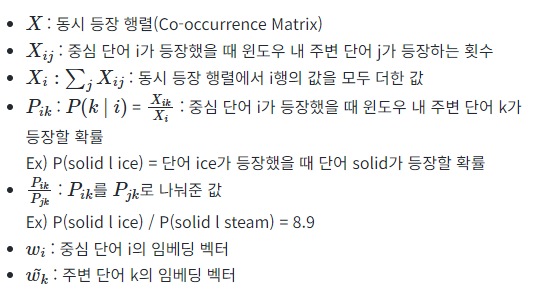


# 9-8. 사전 훈련된 워드 임베딩
- 케라스 임베딩 층 : 케라스의 훈련 데이터의 단어들에 대한 워드 임베딩 도구 Embedding() 사용 => 인공 신경망 구조 관점에서 embedding lqyer 구현
    - input sequence : 정수 인코딩 => dense vector 로 맵핑 ==> 해당 인덱스 값만 가져오는 룩업 테이블
    - 단어 -> 정수로 인코딩 후 룩업 테이블 활용한 결과인 임베딩 벡터 리턴

#### 1. 임베딩 층 == 룩업 테이블 

In [ ]:
vocab_size = 20000 # text data 전체 단어 집합의 크기
output_dim = 128 # 워드 임베딩 후의 임베딩 벡터의 차원
input_length = 500 # 입력 시퀀스의 길이, 샘플 길이 500 => 해당 값 500

v = Embedding(vocab_size, output_dim, input_length=input_length)
# Embedding()은 (number of samples, input_length)인 2D 정수 tensor 입력 -> 3D 실수 tensor return

#### 2. 임베딩 층 사용

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = ['nice great best amazing', 'stop lies', 'pitiful nerd', 'excellent work', 'supreme quality', 'bad', 'highly respectable']
y_train = [1, 0, 0, 1, 1, 0, 1]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1
print('단어 집합 :',vocab_size)


In [ ]:
X_encoded = tokenizer.texts_to_sequences(sentences)
print('정수 인코딩 결과 :',X_encoded)


In [ ]:
max_len = max(len(l) for l in X_encoded)
print('최대 길이 :',max_len)


In [ ]:
X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(y_train)
print('패딩 결과 :')
print(X_train)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

embedding_dim = 4

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=2)


## 2. 사전 훈련된 워드 임베딩 사용
- 훈련 데이터가 적을 경우
- 성능 향상 가능

#### 1. 사전 훈련된 Glove

In [ ]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()


In [ ]:
embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))


In [ ]:
print(embedding_dict['respectable'])
print('벡터의 차원 수 :',len(embedding_dict['respectable']))


In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix)


In [ ]:
print(tokenizer.word_index.items())


In [ ]:
print('단어 great의 맵핑된 정수 :',tokenizer.word_index['great']


In [ ]:
print(embedding_dict['great'])


In [ ]:
embedding_matrix[2]


# 9-10. 임베딩 벡터의 시각화

## 1. 워드 임베딩 모델로부터 2개의 tsv 파일 생성

In [ ]:
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v


https://projector.tensorflow.org/

# 9-11.문서 벡터를 이용한 추천 시스템

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))


In [ ]:
df[:5]

In [ ]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)


In [ ]:
df['cleaned'][:5]


In [ ]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

In [ ]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())


## 2. 사전 훈련된 워드 임베딩 사용하기

In [ ]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")

word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)


## 3. 단어 벡터의 평균 구하기

In [ ]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list


## 4. 추천 시스템 구현하기

In [ ]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)


In [ ]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])


In [ ]:
recommendations("The Murder of Roger Ackroyd")

In [ ]:
recommendations("The Da Vinci Code")

# 9-12. 문서 임베딩 : 워드 임베딩의 평균
- 워드 임베딩 벡터들의 평균 : 그 문장의 벡터
- 임베딩이 잘된 경우의 평균 -> 텍스트 분류 가능

In [ ]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences


## 1. 데이터 로드 및 전처리

In [ ]:
vocab_size = 20000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 :',len(X_train))
print('테스트용 리뷰 개수 :',len(X_test))


In [ ]:
print('훈련 데이터의 첫번째 샘플 :',X_train[0])
print('훈련 데이터의 첫번째 샘플의 레이블 :'y_train[0])


In [ ]:
print('훈련용 리뷰의 평규 길이: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('테스트용 리뷰의 평균 길이: {}'.format(np.mean(list(map(len, X_test)), dtype=int)))


In [ ]:
max_len = 400

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print('X_train의 크기(shape) :', X_train.shape)
print('X_test의 크기(shape) :', X_test.shape)


## 2. 모델 설계

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))

# 모든 단어 벡터의 평균을 구한다.
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('embedding_average_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=[es, mc], validation_split=0.2)


In [ ]:
loaded_model = load_model('embedding_average_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))


# 9-13 Dov2Vec 으로 공시 사업보고서 유사도 계산하기

In [ ]:
# dart.csv 파일 다운로드
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XS0UlE8gNNTRjnL6e64sMacOhtVERIqL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XS0UlE8gNNTRjnL6e64sMacOhtVERIqL" -O dart.csv && rm -rf /tmp/cookies.txt


In [ ]:
# 형태소 분석기 Mecab 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)


In [ ]:
import pandas as pd
from konlpy.tag import Mecab
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm


In [ ]:
df = pd.read_csv('/content/dart.csv',  sep=',')
df = df.dropna()
df


In [ ]:
mecab = Mecab()

tagged_corpus_list = []

for index, row in tqdm(df.iterrows(), total=len(df)):
  text = row['business']
  tag = row['name']
  tagged_corpus_list.append(TaggedDocument(tags=[tag], words=mecab.morphs(text)))

print('문서의 수 :', len(tagged_corpus_list))


In [ ]:
tagged_corpus_list[0]


## 2. Doc2Vec 학습 및 테스트

In [ ]:
from gensim.models import doc2vec


In [ ]:
model = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, workers=8, window=8)

# Vocabulary 빌드
model.build_vocab(tagged_corpus_list)
print(f"Tag Size: {len(model.docvecs.doctags.keys())}", end=' / ')

# Doc2Vec 학습
model.train(tagged_corpus_list, total_examples=model.corpus_count, epochs=50)

# 모델 저장
model.save('dart.doc2vec')


In [ ]:
similar_doc = model.docvecs.most_similar('동화약품')
print(similar_doc)


In [ ]:
similar_doc = model.docvecs.most_similar('하이트진로')
print(similar_doc)


# 9-14. 실전! 한국어 위키피디아로 Word2Vec 학습

In [ ]:
pip install wikiextractor


In [ ]:
Mecab 설치 필요

In [ ]:
!wget https://dumps.wikimedia.org/kowiki/latest/kowiki-latest-pages-articles.xml.bz2


In [ ]:
!python -m wikiextractor.WikiExtractor kowiki-latest-pages-articles.xml.bz2


In [ ]:
import os
import re


In [ ]:
def list_wiki(dirname):
    filepaths = []
    filenames = os.listdir(dirname)
    for filename in filenames:
        filepath = os.path.join(dirname, filename)

        if os.path.isdir(filepath):
            # 재귀 함수
            filepaths.extend(list_wiki(filepath))
        else:
            find = re.findall(r"wiki_[0-9][0-9]", filepath)
            if 0 < len(find):
                filepaths.append(filepath)
    return sorted(filepaths)


In [ ]:
filepaths = list_wiki('text')
len(filepaths)


In [ ]:
with open("output_file.txt", "w") as outfile:
    for filename in filepaths:
        with open(filename) as infile:
            contents = infile.read()
            outfile.write(contents)


## 2. 형태소 분석

In [ ]:
from tqdm import tqdm
from konlpy.tag import Mecab 


In [ ]:
mecab = Mecab()


In [ ]:
f = open('output_file.txt', encoding="utf8")
lines = f.read().splitlines()
print(len(lines))


In [ ]:
result = []

for line in tqdm(lines):
  # 빈 문자열이 아닌 경우에만 수행
  if line:
    result.append(mecab.morphs(line))


## 3. Word2Vec 학습

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(result, size=100, window=5, min_count=5, workers=4, sg=0)


In [ ]:
model_result1 = model.wv.most_similar("대한민국")
print(model_result1)


In [ ]:
model_result2 = model.wv.most_similar("어벤져스")
print(model_result2)
